In [1]:
%pip install librosa 
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import librosa

In [3]:
import pandas as pd
metadata = pd.read_csv('./voices_dataset/speakers_all.csv')
metadata.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,native_class,patientId,Unnamed: 11
0,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,True,ivan1,NaN
1,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,True,ivan1,NaN
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,True,ivan1,NaN
3,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,True,ivan1,NaN
4,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,True,ivan1,NaN
5,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,3,ivory coast,False,True,ivan1,NaN
6,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,False,True,ivan1,NaN
7,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,False,True,ivan1,NaN
8,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,False,True,ivan1,NaN
9,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,False,True,ivan1,NaN


In [4]:
data_to_use = metadata[metadata['native_class'] == False]
# data_to_use['native_language'].value_counts()
metadata = data_to_use
metadata['native_language'].value_counts()

arabic       102
dutch         42
cantonese     23
amharic       20
bulgarian     18
bengali       17
Name: native_language, dtype: int64

In [5]:
## Extracting MFCC'S for every audio file
audio_dataset_path = './voices_dataset/recordings_wav/'

In [6]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [7]:
import numpy as np
import os
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]) + str('-gain.wav'))
    final_class_labels=row["native_language"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

222it [01:25,  2.60it/s]


In [8]:
### converting extracted_features to pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'native_language'])
extracted_features_df.head(10)

,feature,native_language
0,"[-341.28854, 104.94958, 29.585915, 36.79861, 1...",amharic
1,"[-383.52597, 105.40056, 18.184828, 32.105137, ...",amharic
2,"[-299.42505, 88.47966, 17.990448, 40.02904, 4....",amharic
3,"[-297.64392, 105.14598, 21.00998, 48.18276, 5....",amharic
4,"[-330.03546, 89.63933, 19.428076, 37.235043, 1...",amharic
5,"[-323.99893, 143.62692, 8.782082, 38.291607, -...",amharic
6,"[-351.30518, 131.708, 4.8169694, 30.451023, -0...",amharic
7,"[-347.50696, 117.743904, -30.558903, 24.777813...",amharic
8,"[-300.79492, 89.627144, 5.064329, 22.388256, 8...",amharic
9,"[-362.49753, 88.59295, -23.98448, 22.366228, -...",amharic


In [9]:
## Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['native_language'].tolist())

In [10]:
X.shape

(222, 128)

In [11]:
### Label encoding
y = np.array(pd.get_dummies(y))

In [79]:
### Train Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [80]:
X_train.shape

(155, 128)

In [81]:
X_test.shape

(67, 128)

In [82]:
y_train.shape

(155, 6)

In [83]:
y_test.shape

(67, 6)

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [85]:
## number of countries
num_labels = y.shape[1]
num_labels

6

In [86]:
model = Sequential()
### first layer
model.add(Dense(250, input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
### second layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
### third layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###fourth layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
### final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 250)               32250     
                                                                 
 activation_15 (Activation)  (None, 250)               0         
                                                                 
 dropout_12 (Dropout)        (None, 250)               0         
                                                                 
 dense_16 (Dense)            (None, 250)               62750     
                                                                 
 activation_16 (Activation)  (None, 250)               0         
                                                                 
 dropout_13 (Dropout)        (None, 250)               0         
                                                                 
 dense_17 (Dense)            (None, 250)              

In [88]:
model.compile(
  loss='categorical_crossentropy',
  metrics=['accuracy','mae'],
  optimizer='adam'
)

In [89]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

start = datetime.now()

history = model.fit(
  X_train,
  y_train,
  batch_size=num_batch_size,
  epochs=num_epochs,
  validation_data=(X_test, y_test),
  callbacks=[checkpointer, early_stop],
  verbose=1
)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
1/5 [=====>........................] - ETA: 2s - loss: 52.1000 - accuracy: 0.0312 - mae: 0.3229
Epoch 1: val_loss improved from inf to 9.60229, saving model to saved_models/audio_classification.hdf5
5/5 [==============================] - 1s 65ms/step - loss: 36.5558 - accuracy: 0.1548 - mae: 0.2807 - val_loss: 9.6023 - val_accuracy: 0.5373 - val_mae: 0.1542
Epoch 2/200
1/5 [=====>........................] - ETA: 0s - loss: 21.8946 - accuracy: 0.3125 - mae: 0.2286
Epoch 2: val_loss improved from 9.60229 to 6.97200, saving model to saved_models/audio_classification.hdf5
5/5 [==============================] - 0s 20ms/step - loss: 24.6023 - accuracy: 0.2839 - mae: 0.2378 - val_loss: 6.9720 - val_accuracy: 0.5373 - val_mae: 0.1542
Epoch 3/200
1/5 [=====>........................] - ETA: 0s - loss: 26.2238 - accuracy: 0.2188 - mae: 0.2498
Epoch 3: val_loss improved from 6.97200 to 2.73056, saving model to saved_models/audio_classification.hdf5
5/5 [==============================] 

In [90]:
test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_accuracy

[1.6859490871429443, 0.41791045665740967, 0.26992273330688477]

In [91]:
def plot_history(history):     
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mae'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['accuracy'],'b',
          label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

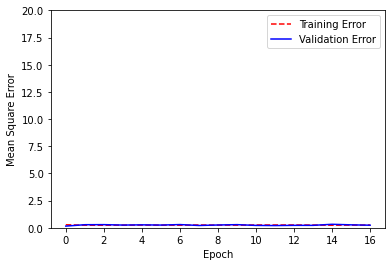

In [92]:
plot_history(history)

In [93]:
### testing the model
test_filename = './voices_dataset/recordings_wav/amharic14-gain.wav'
audio, sample_rate = librosa.load(test_filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
# print(mfccs_scaled_features)

# using juts one item
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)
#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)

predicted_label = model.predict(mfccs_scaled_features)
predicted_classes = np.argmax(predicted_label, axis=1)
predicted_classes

array([5])

In [94]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(metadata['native_language']))

prediction_class = labelencoder.inverse_transform(predicted_classes)
prediction_class

array(['dutch'], dtype=object)

In [95]:
metadata.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,native_class,patientId,Unnamed: 11
18,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,False,ivan3,NaN
19,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,False,ivan3,NaN
20,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,False,ivan5,NaN
21,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,False,ivan5,NaN
22,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,False,ivan5,NaN
23,31.0,12.0,"addis ababa, ethiopia",amharic14,amharic,male,1515,ethiopia,False,False,ivan5,NaN
24,23.0,6.0,"addis ababa, ethiopia",amharic15,amharic,male,1516,ethiopia,False,False,ivan5,NaN
25,36.0,11.0,"werder, ethiopia",amharic16,amharic,male,1854,ethiopia,False,False,ivan5,NaN
26,21.0,9.0,"addis ababa, ethiopia",amharic17,amharic,male,1906,ethiopia,False,False,ivan5,NaN
27,20.0,2.0,"addis ababa, ethiopia",amharic18,amharic,female,2017,ethiopia,False,False,ivan5,NaN


In [96]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

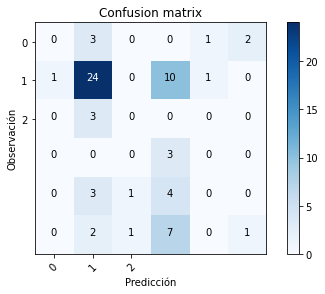

In [97]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))